# DNN Analysis
This notebook reads in the `scaler` used to transform the data such that $\mu=0$ and $\sigma=1$, and it reads in the trained optimized DNN.  The analysis consists of:
> 1. Computing the sample mean and RMS
> 2. Parameterizing the energy response correction to the model predicted energy responses
> 3. Applying the event-by-event parameterization to the model predicted energy distributions
> 4. Evaluating the energy resolution and energy response using Gaussian fits
> 5. Producing plots of:
>> i. The energy resolution plotted against $1/\sqrt{P_b}$ <br>
>> ii. The energy response ratio <br>
>> iii. The corrected vs raw beam distribution sigma <br>
>> iv. The parameterization curve fit <br>
>> v. The individual energy distributions sorted by nominal beam energy <br>
>> vi. (Optional) Interpolation plot <br>

### Import Libraries

In [322]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random, math
import re
import os, sys
import datetime, time
from collections import OrderedDict
from os import listdir
from os.path import isfile, join
from array import array
import tensorflow as tf
import keras
from keras import backend
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
from scipy.optimize import curve_fit
from scipy.stats import norm, linregress
print('Using Keras version '+ str(keras.__version__))

Using Keras version 2.2.0


### Define the analysis parameters

In [323]:
data_dir = "./Pion Test Beam"
model_path = "DNN model/2019-07-16/DNN Model Trained 07-16 (15).h5"
scaler_path = "DNN model/2019-07-16/DNN Scaler 07-16 (15).joblib"
output_dir = "Analysis Results/"
CUSTOM_LOSS = True # if a custom loss function was used for training, set to 'True'
INTERPOLATION = False # Do not edit this, it will change automatically
SCALING = True
train_list = [  # edit this according to the training model data set
    2,
    3,
    4,
    5,
    6,
    7,
    8,
    9,
    #20,
    30,
    50,
    100,
    150,
    200,
    300
]

if len(train_list) < 15:
    INTERPOLATION = True

tag = model_path[-13:-3] # automatically reads in the tag from the input path
print('Running analysis for DNN ' + tag)
print('Interpolation is: ' + str(INTERPOLATION))

Running analysis for DNN 07-16 (15)
Interpolation is: True


Viewing range of the energy distribution plots

In [324]:
WINDOWS = {
    2: [-3,8],
    3: [-3,9],
    4: [-3,11],
    5: [-3,13],
    6: [-3,15],
    7: [-2,16],
    8: [-1,17],
    9: [0,24],
    20: [0,54],
    30: [0,60],
    50: [0,100],
    100: [0,215],
    150: [20,280],
    200: [100,350],
    300: [150,450]
}

### Load in the data

In [325]:
files_inter = [f for f in listdir(data_dir) if isfile(join(data_dir, f))] # reads in file names

# Declare the file data dicts
files99 = {} # ECal = EB (barrel)
files33 = {} # HO this data is not used for the DNN but will be populated
files34 = {} # HCal = HB (barrel)

for i in files_inter: # iterates through the different energy labels to populate the file data dicts
    print('Loading {}'.format(i))
    buffer99 = []
    buffer34 = []
    buffer33 = []
    file = open(data_dir + '/' + i) 
    data = file.readlines() # data is a list containing j lines
    for j in data:
        # fromstring turns a sentence (l.strip) into a 1D array
        line = np.fromstring(j.strip(),sep = " ") # 1D array
        if len(line) == 9:
            buffer99.append(line)
        if len(line) == 4:
            buffer34.append(line)
        if len(line) == 3:
            buffer33.append(line)
    files99[i] = buffer99
    files34[i] = buffer34
    files33[i] = buffer33

Loading pi-100GeV.txt
Loading pi-150GeV.txt
Loading pi-200GeV.txt
Loading pi-20GeV.txt
Loading pi-2GeV.txt
Loading pi-300GeV.txt
Loading pi-30GeV.txt
Loading pi-3GeV.txt
Loading pi-4GeV.txt
Loading pi-50GeV.txt
Loading pi-5GeV.txt
Loading pi-6GeV.txt
Loading pi-7GeV.txt
Loading pi-8GeV.txt
Loading pi-9GeV.txt


### Some helper functions for shaping the HB and EB images

In [326]:
def shapeimages9x9(lines):
    img9x9 = {}
    # keys identifies the dataset 'labels' from 'lines' (i.e. pi-9GeV)
    for key in lines.keys():
        counter = 1
        imgs = []
        img = []
        for line in lines[key]:
            # extend adds 'line' to the list 'img'
            img.extend(line)
            if counter%9 == 0:
                imgs.append(img)
                img = []
            counter += 1
        img9x9[key] = imgs
    return img9x9

def shapeimages3x4(lines):
    img3x4 = {}
    for key in lines.keys():
        counter = 1
        imgs = []
        img = []
        for line in lines[key]:
            img.extend(line)
            if counter%3 == 0:
                imgs.append(img)
                img = []
            counter += 1
        img3x4[key] = imgs
    return img3x4

Apply the image shaping and initialize to dicts:

In [327]:
img9x9 = shapeimages9x9(files99)
img3x4 = shapeimages3x4(files34)

### Load in the trained model

In [328]:
def customLoss(y_true, y_pred):
    def _logcosh(x):
        return x + backend.softplus(-2. * x) - backend.log(2.)
    return backend.mean(_logcosh((y_pred - y_true) / y_true), axis = -1)

In [329]:
# load in the trained model
model_opt = None
if CUSTOM_LOSS == True:
    print('Using custom loss function.')
    model_opt = tf.keras.models.load_model(model_path,
                                        custom_objects = {'customLoss': customLoss})
if CUSTOM_LOSS == False:
    model_opt = tf.keras.models.load_model(model_path)
model_opt.summary()

Using custom loss function.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 941)               88454     
_________________________________________________________________
dense_2 (Dense)              (None, 470)               442740    
_________________________________________________________________
dropout_1 (Dropout)          (None, 470)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 471       
Total params: 531,665
Trainable params: 531,665
Non-trainable params: 0
_________________________________________________________________


### Declare all the containers to be used for the analysis:

In [330]:
x = []
y = []

# for interpolation
pred_mu_smp = {}
pred_sigma_smp = {}
pred_res_smp = {}
pred_det_smp = {}
pred_filter_smp = {}

raw_mu = {}
raw_sigma = {}
raw_res = {}
raw_det = {}
raw_filter = {}

raw_res_list = []
pred_res_smp_list = []

raw_eng_list = []
pred_eng_smp_list = []

raw_sigma_list = []
pred_sigma_smp_list = []

nom_eng_smp_list = []

x_e = {}
x_o = {}

### Predict using a trained model and get fits

In [331]:
for i in img9x9:
    print('Processing {}'.format(i))
    img_EB = np.array(img9x9[i])
    img_HB = np.array(img3x4[i])
    img_comb_arr = []
    for j in range(np.shape(img9x9[i])[0]):
        img_comb_buffer = np.concatenate((img_EB[j], img_HB[j]))
        img_comb_arr.append(img_comb_buffer)
            
    img_comb = np.array(img_comb_arr)
        
    x.extend(img_comb)
    energy = np.int(re.findall(r'\d+',i)[0])
    y.extend(np.full(np.shape(img9x9[i])[0], energy))

scaler = None
x_pp = None
    
if SCALING == True:
    scaler = joblib.load( scaler_path )
    x_pp = scaler.transform(x)
    
for energy in set(y):
    x_e[energy] = []
    x_o[energy] = []
for i in range(len(y)):
    if SCALING == True:
        x_e[y[i]].append(x_pp[i])
    else:
        x_e[y[i]].append(x[i])
    x_o[y[i]].append(x[i])

Processing pi-20GeV.txt
Processing pi-30GeV.txt
Processing pi-4GeV.txt
Processing pi-100GeV.txt
Processing pi-200GeV.txt
Processing pi-300GeV.txt
Processing pi-3GeV.txt
Processing pi-5GeV.txt
Processing pi-6GeV.txt
Processing pi-150GeV.txt
Processing pi-2GeV.txt
Processing pi-50GeV.txt
Processing pi-7GeV.txt
Processing pi-8GeV.txt
Processing pi-9GeV.txt


In [332]:
START_TIME = time.time()

# predict on individual beam energies and fit the corrected distributions
for energy in sorted(set(x_e)):
    NOW_TIME = time.time()
    x_pred_e = model_opt.predict(np.array(x_e[energy]))
    raw = [i.sum() for i in x_o[energy]]
        
    filter_quartile_pred = np.percentile(x_pred_e,
                                [0.5,99.5]) # only consider inner 99th percentile to exclude outliers
    filter_quartile_raw = np.percentile(x_o[energy],
                                [0.5,99.5])
        
    pred_filter_smp[energy] = []
    raw_filter[energy] = []
        
    for p in x_pred_e:
        if p >= filter_quartile_pred[0] and p <= filter_quartile_pred[1]:
            pred_filter_smp[energy].append(p)
    for r in raw:
        if r >= filter_quartile_raw[0] and r <= filter_quartile_raw[1]:
            raw_filter[energy].append(r)

    mu_smp_pred, sigma_smp_pred = np.mean(pred_filter_smp[energy]), np.std(pred_filter_smp[energy])
    mu_smp_raw, sigma_smp_raw = np.mean(raw_filter[energy]), np.std(raw_filter[energy])
            
    pred_mu_smp[energy] = mu_smp_pred
    pred_sigma_smp[energy] = sigma_smp_pred
    pred_res_smp[energy] = sigma_smp_pred / mu_smp_pred
    pred_det_smp[energy] = x_pred_e
        
    pred_res_smp_list.append( sigma_smp_pred / mu_smp_pred )
    pred_eng_smp_list.append( mu_smp_pred )
    pred_sigma_smp_list.append( sigma_smp_pred )
    
    raw_mu[energy] = mu_smp_raw
    raw_sigma[energy] = sigma_smp_raw
    raw_res[energy] = sigma_smp_raw / mu_smp_raw
    raw_det[energy] = raw
        
    raw_res_list.append( sigma_smp_raw / mu_smp_raw )
    raw_eng_list.append( mu_smp_raw )
    raw_sigma_list.append( sigma_smp_raw )
        
    nom_eng_smp_list.append( energy )
    
    print('Finished processing {} in {} seconds'.format(energy, time.time() - NOW_TIME))

print('========================')
print('Finished in {} secs'.format(time.time() - START_TIME))

Finished processing 2 in 0.868947982788 seconds
Finished processing 3 in 1.40149903297 seconds
Finished processing 4 in 1.75110697746 seconds
Finished processing 5 in 2.66695189476 seconds
Finished processing 6 in 2.47673797607 seconds
Finished processing 7 in 2.64237499237 seconds
Finished processing 8 in 1.25417590141 seconds
Finished processing 9 in 2.21035313606 seconds
Finished processing 20 in 1.27610516548 seconds
Finished processing 30 in 0.690768003464 seconds
Finished processing 50 in 1.00782203674 seconds
Finished processing 100 in 1.16357493401 seconds
Finished processing 150 in 0.675182819366 seconds
Finished processing 200 in 0.55864405632 seconds
Finished processing 300 in 2.21746993065 seconds
Finished in 22.8668990135 secs


### Plot the predicted vs raw energy distributions

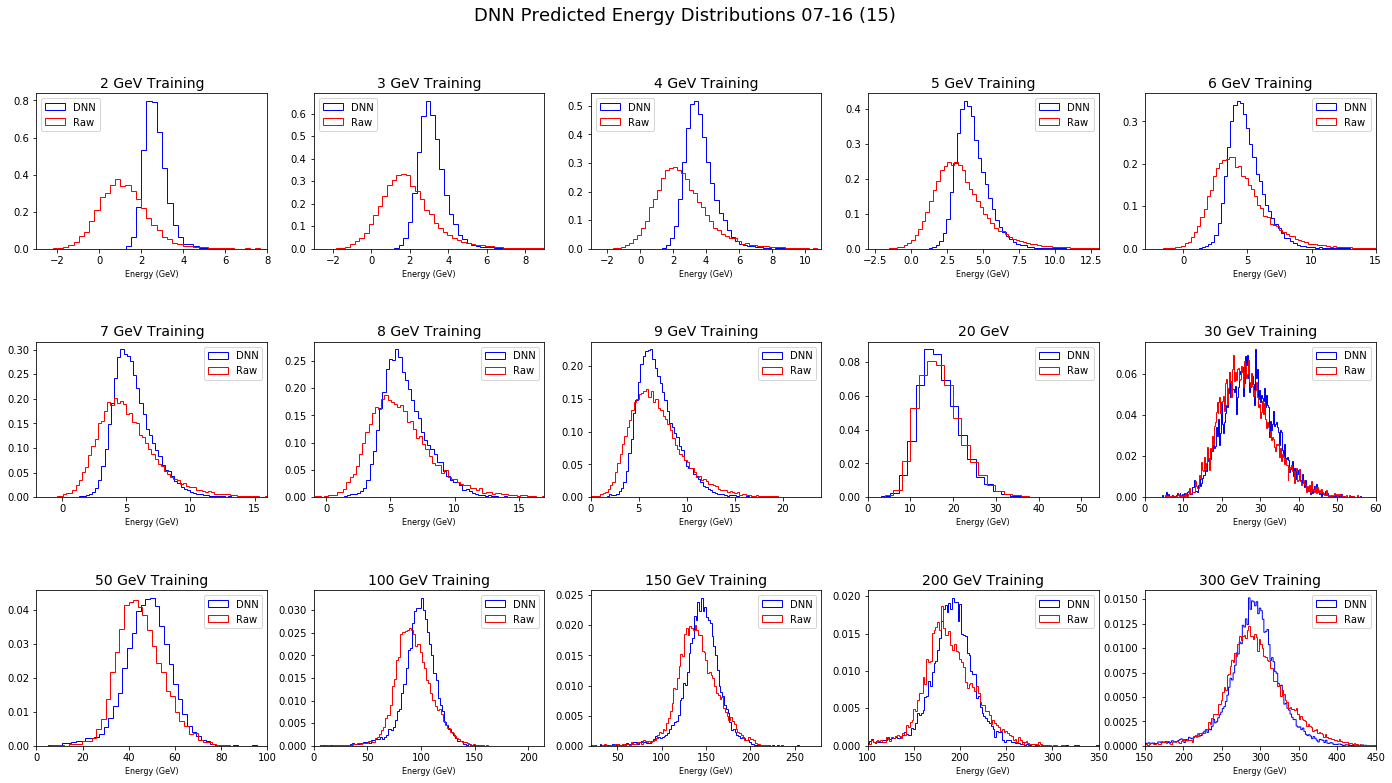

In [333]:
plt.figure(figsize=(24,12))

plt.suptitle('DNN Predicted Energy Distributions {}'.format(tag),
            fontsize = 18)

fig_num = 1

for i in sorted(set(x_e)):
    plt.subplot(3, 5, fig_num)
    fig_num += 1
    
    BIN_PRED = int(np.ceil(max(pred_det_smp[i]) - min(pred_det_smp[i]))*4)
    if BIN_PRED > 300:
        BIN_PRED = int(np.ceil(max(pred_det_smp[i]) - min(pred_det_smp[i]))*0.5)

    plt.hist(np.asarray(pred_det_smp[i]), BIN_PRED,
        histtype = 'step', density = 'True',
        label = 'DNN',
        color = 'b')
    
    BIN_RAW = int(np.ceil((max(raw_det[i]) - min(raw_det[i])))*4)
    if BIN_RAW > 300:
        BIN_RAW = int(np.ceil(max(raw_det[i]) - min(pred_det_smp[i]))*0.5)

    plt.hist(np.asarray(raw_det[i]), BIN_RAW,
        histtype = 'step', density = 'True',
        label = 'Raw',
        color = 'r')
    
    if i in train_list:
        plt.title('{} GeV Training'.format(i), fontsize = 14)
    else:
        plt.title('{} GeV'.format(i), fontsize = 14)
    plt.xlabel('Energy (GeV)', fontsize = 8)
    plt.xlim(WINDOWS[i][0], WINDOWS[i][1])
    plt.subplots_adjust(hspace = 0.6)
    
    plt.legend(loc = 'best')

plt.savefig(output_dir + 'DNN Predicted Energy Distributions ' + tag + '.png')

plt.show()

In [334]:
df = pd.DataFrame({'Pred Mean' : [pred_mu_smp[i] for i in pred_mu_smp],
                   'Pred Sigma' : [pred_sigma_smp[i] for i in pred_sigma_smp],
                   'Pred Resolution' : [pred_res_smp[i] for i in pred_res_smp],
                   'Raw Mean' : [raw_mu[i] for i in raw_mu],
                   'Raw Sigma' : [raw_sigma[i] for i in raw_sigma],
                   'Raw Resolution' : [raw_res[i] for i in raw_res]},
                         pred_mu_smp).sort_values(by = ['Pred Mean'])
df.to_csv(output_dir + 'DNN Sample Mean and RMS ' + tag + '.txt',
         sep = ' ', float_format = '%.5f', index = True, header = True)
df

,Pred Mean,Pred Resolution,Pred Sigma,Raw Mean,Raw Resolution,Raw Sigma
2,2.662240,0.193277,0.514549,0.168561,1.570513,0.264727
3,3.164761,0.217445,0.688163,0.346799,0.911766,0.316199
4,3.635258,0.237765,0.864338,0.571684,0.653447,0.373565
5,4.247331,0.253514,1.076757,0.883231,0.497115,0.439067
6,4.896471,0.266614,1.305469,1.243767,0.394652,0.490855
7,5.565490,0.274731,1.529014,1.505288,0.342574,0.515672
8,6.183555,0.280863,1.736733,1.790475,0.320756,0.574305
9,6.976456,0.283987,1.981223,2.143949,0.302302,0.648119
20,16.853886,0.275709,4.646770,6.319412,0.155216,0.980871
30,27.238884,0.238213,6.488666,10.022128,0.208423,2.088838


### Determine the parameterization

In [335]:
def functionParam(x,a,b,c,d):
    return x - a*np.cos(b*x**c)/np.exp(d*x)

[3.5        1.30767974 0.8        1.2       ]


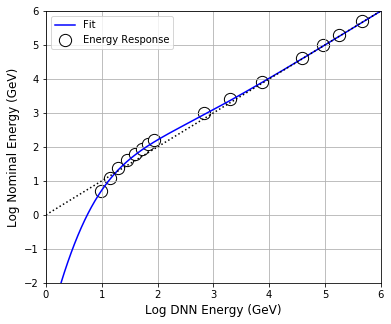

In [338]:
log_smp_eng = np.around(np.log(np.asarray(pred_eng_smp_list)),3)
log_nom_eng = np.around(np.log(np.asarray(nom_eng_smp_list)),3)
x_array = np.linspace(0,6,200)

opt_param, _ = curve_fit(functionParam,
                        log_smp_eng,
                        log_nom_eng,
                        p0 = [3.5, 1.3, 0.8, 1.2], # best guess based on previous optimization run
                        ) 
print(opt_param)
plt.close()
plt.figure(figsize = (6,5))
plt.scatter(log_smp_eng, log_nom_eng,
           s = 150, label = 'Energy Response',
           facecolor = 'w',
           edgecolor = 'k')
plt.plot(x_array, functionParam(x_array,
                                opt_param[0],
                                opt_param[1],
                                opt_param[2],
                                opt_param[3]),
        color = 'b',
        label = 'Fit')
plt.plot(np.linspace(0,6,100), np.linspace(0,6,100),
        linestyle = ':',
        color = 'k')
plt.grid(which = 'major', linestyle = '-')
plt.grid(which = 'minor', linestyle = ':')
plt.legend(loc = 'best')

plt.xlabel('Log DNN Energy (GeV)',
          fontsize = 12)
plt.xlim(0, 6)

plt.ylabel('Log Nominal Energy (GeV)',
          fontsize = 12)
plt.ylim(-2, 6)

plt.savefig(output_dir + 'DNN Parameterization ' + tag + '.png')

plt.show()

### Apply the parameterization
First declare some containers

In [339]:
pred_mu_param = {}
pred_sigma_param = {}
pred_res_param = {}
pred_det_param = {}
pred_fit_filter = {}

pred_res_param_list = []
pred_eng_param_list = []
pred_sigma_param_list = []

raw_mu_fit = {}
raw_sigma_fit = {}
raw_res_fit = {}
raw_det_fit = {}
raw_fit_filter = {}

raw_res_fit_list = []
raw_eng_fit_list = []
raw_sigma_fit_list = []

nom_eng_param_list = []

In [340]:
FIT_PERC_PRED = {
     2: [0,96],
     3: [0,96],
     4: [0,96],
     5: [0,96],
     6: [0,96],
     7: [0,96],
     8: [0,96],
     9: [0,96],
     20: [0,98],
     30: [0.5,99.5],
     50: [1.5,98.5],
     100: [2,99.5],
     150: [5,99.5],
     200: [4.5,99],
     300: [7,96]
}

FIT_PERC_RAW = {
     2: [0,98],
     3: [0,98],
     4: [0,95],
     5: [0,94],
     6: [0,94],
     7: [0,92],
     8: [0.5,92],
     9: [0.5,93],
     20: [0,93.5],
     30: [0.5,95],
     50: [0.5,95],
     100: [0.5,97],
     150: [0,97],
     200: [0.5,97],
     300: [2,95]
}

In [341]:
START_TIME = time.time()

# predict on individual beam energies and fit the corrected distributions
for energy in sorted(set(x_e)):
    NOW_TIME = time.time()
    x_pred_e = np.asarray(model_opt.predict(np.array(x_e[energy])))
    x_pred_log = np.log([item for item in x_pred_e if (item > 0)])
    x_pred_param = np.exp(functionParam(x_pred_log,
                                        opt_param[0],
                                        opt_param[1],
                                        opt_param[2],
                                        opt_param[3]))
    x_pred_param = x_pred_param[~np.isnan(x_pred_param)] # removes NaN values
    
    raw_fit = [i.sum() for i in x_o[energy]] # compiles the raw energy of an image
        
    filter_quartile_pred = np.percentile(x_pred_param,
                                [FIT_PERC_PRED[energy][0],
                                FIT_PERC_PRED[energy][1]])
    filter_quartile_raw = np.percentile(raw_fit,
                                [FIT_PERC_RAW[energy][0],
                                FIT_PERC_RAW[energy][1]])
        
    pred_fit_filter[energy] = []
    raw_fit_filter[energy] = []
        
    for p in x_pred_param:
        if p >= filter_quartile_pred[0] and p <= filter_quartile_pred[1]:
            pred_fit_filter[energy].append(p)

    for r in raw_fit:
        if r >= filter_quartile_raw[0] and r <= filter_quartile_raw[1]:
            raw_fit_filter[energy].append(r)
    
    mu_fit_pred, sigma_fit_pred = norm.fit(pred_fit_filter[energy])
    mu_fit_raw, sigma_fit_raw = norm.fit(raw_fit_filter[energy])

    pred_mu_param[energy] = mu_fit_pred
    pred_sigma_param[energy] = sigma_fit_pred
    pred_res_param[energy] = sigma_fit_pred / mu_fit_pred
    pred_det_param[energy] = x_pred_param
        
    pred_res_param_list.append( sigma_fit_pred / mu_fit_pred )
    pred_eng_param_list.append( mu_fit_pred )
    pred_sigma_param_list.append( sigma_fit_pred )
    
    raw_mu_fit[energy] = mu_fit_raw
    raw_sigma_fit[energy] = sigma_fit_raw
    raw_res_fit[energy] = sigma_fit_raw / mu_fit_raw
    raw_det_fit[energy] = raw_fit

    raw_res_fit_list.append( sigma_fit_raw / mu_fit_raw )
    raw_eng_fit_list.append( mu_fit_raw )
    raw_sigma_fit_list.append( sigma_fit_raw )
        
    nom_eng_param_list.append( energy )
    print('Fitting for {} GeV took {} s'.format(energy, time.time() - NOW_TIME))
    
print('Finished in {} secs'.format(time.time() - START_TIME))

Fitting for 2 GeV took 0.763779878616 s


/usr/local/bin/start_ipykernel.py:2: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':


Fitting for 3 GeV took 1.82123303413 s
Fitting for 4 GeV took 2.17385721207 s
Fitting for 5 GeV took 2.76634287834 s
Fitting for 6 GeV took 2.39927911758 s
Fitting for 7 GeV took 2.56202483177 s
Fitting for 8 GeV took 1.2701151371 s
Fitting for 9 GeV took 2.02105093002 s
Fitting for 20 GeV took 0.898810148239 s
Fitting for 30 GeV took 0.434809923172 s
Fitting for 50 GeV took 0.872620105743 s
Fitting for 100 GeV took 1.12004494667 s
Fitting for 150 GeV took 0.808476924896 s
Fitting for 200 GeV took 0.69077205658 s
Fitting for 300 GeV took 2.07175517082 s
Finished in 22.6885459423 secs


### Plot the Gaussian fit corrected energy distribution
There are two options for plotting:
> 1. Plot with the Gaussian fit shown
> 2. Plot without the Gaussian fit shown

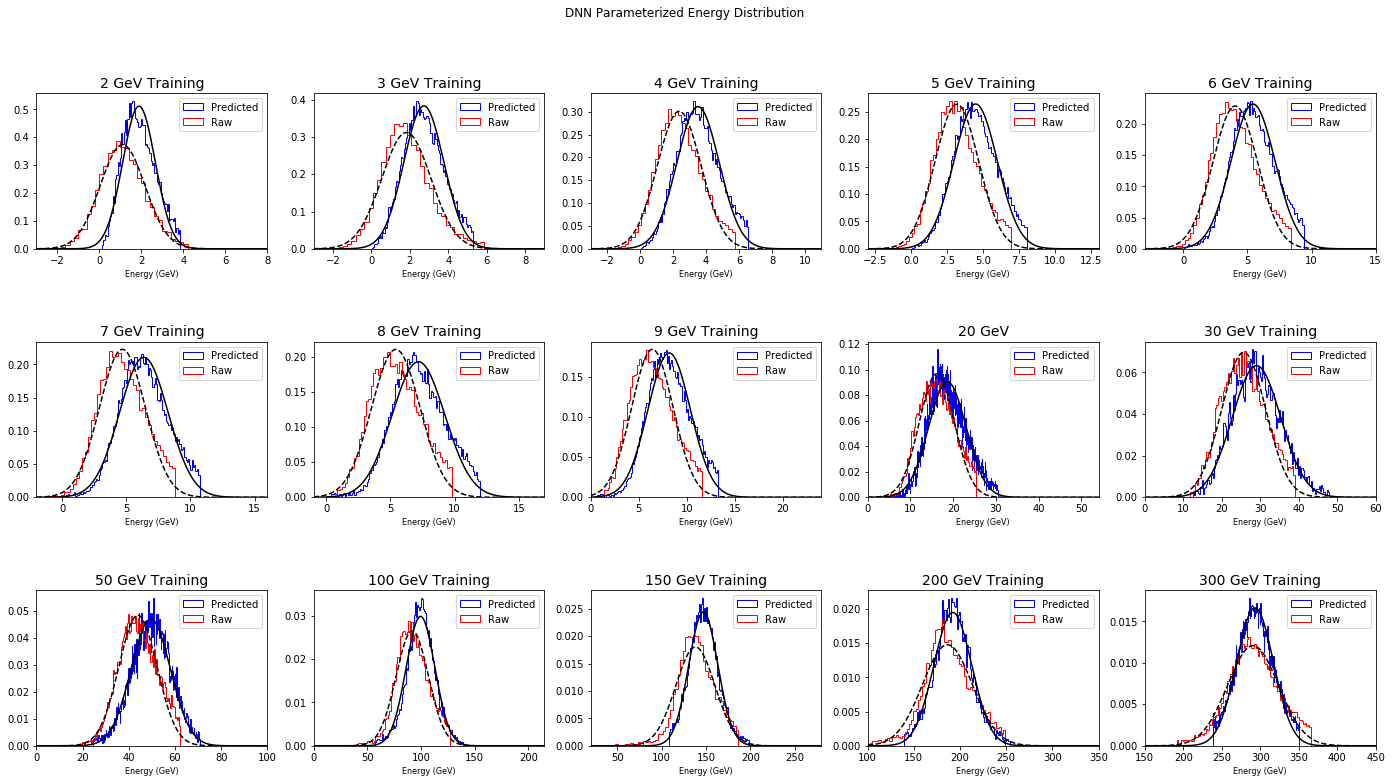

In [342]:
OPTION = 1

plt.figure(figsize=(24,12))

plt.suptitle('DNN Parameterized Energy Distribution')

fig_num = 1

for i in sorted(set(x_e)):
    plt.subplot(3, 5, fig_num)
    fig_num += 1

    BIN_PRED = int(np.ceil(np.sqrt((max(pred_det_param[i]) - min(pred_det_param[i]))))*4)
    if i < 100:
        BIN_PRED = BIN_PRED * 4
        
    BIN_RAW = int(np.ceil(np.sqrt((max(raw_det_fit[i]) - min(raw_det_fit[i]))))*4)
    if i < 100:
        BIN_RAW = BIN_RAW * 2
    
    if OPTION == 1:
        fit_range = np.linspace(WINDOWS[i][0],
                        WINDOWS[i][1],
                        1000)
        plt.plot(fit_range, norm.pdf(fit_range, pred_mu_param[i], pred_sigma_param[i]),
               'k-', linewidth = 1.5)
    
        plt.hist(np.asarray(pred_fit_filter[i]),
            BIN_PRED,
            histtype = 'step', density = 'True',
            label = 'Predicted',
            color = 'b')
    
    if OPTION == 2:
        if (max(pred_det_param[i]) - min(pred_det_param[i])) > 400:
            BIN_PRED = BIN_PRED * 3
        plt.hist(np.asarray(pred_det_param[i]),
            BIN_PRED*4,
            histtype = 'step', density = 'True',
            label = 'Predicted',
            color = 'b')
    
    if OPTION == 1:
        fit_range_raw = np.linspace(WINDOWS[i][0],
                            WINDOWS[i][1],
                            1000)
        plt.plot(fit_range_raw, norm.pdf(fit_range_raw, raw_mu_fit[i], raw_sigma_fit[i]),
           'k--', linewidth = 1.5)
    
        plt.hist(np.asarray(raw_fit_filter[i]),
            BIN_RAW,
            histtype = 'step', density = 'True',
            label = 'Raw',
            color = 'r')
    
    if OPTION == 2:
        plt.hist(np.asarray(raw_det_fit[i]),
            BIN_RAW*4,
            histtype = 'step', density = 'True',
            color = 'r',
            label = 'Raw')
    
    if i in train_list:
        plt.title('{} GeV Training'.format(i), fontsize = 14)
    else:
        plt.title('{} GeV'.format(i), fontsize = 14)
    plt.xlabel('Energy (GeV)', fontsize = 8)
    plt.xlim(WINDOWS[i][0], WINDOWS[i][1])
    plt.subplots_adjust(hspace = 0.6)
    
    plt.legend(loc = 'best')

plt.savefig(output_dir + 'DNN Parameterized Energy Distribution ' + tag + '.png')

plt.show()

In [343]:
df_param = pd.DataFrame({'Pred Mean' : [pred_mu_param[i] for i in pred_mu_param],
                   'Pred Sigma' : [pred_sigma_param[i] for i in pred_sigma_param],
                   'Pred Resolution' : [pred_res_param[i] for i in pred_res_param],
                   'Raw Mean' : [raw_mu_fit[i] for i in raw_mu_fit],
                   'Raw Sigma' : [raw_sigma_fit[i] for i in raw_sigma_fit],
                   'Raw Resolution' : [raw_res_fit[i] for i in raw_res_fit]},
                         pred_mu_param).sort_values(by = ['Pred Mean'])
df_param.to_csv(output_dir + 'DNN Parameterized Mean and RMS ' + tag + '.txt',
         sep = ' ', float_format = '%.5f', index = True, header = True)
df_param

,Pred Mean,Pred Resolution,Pred Sigma,Raw Mean,Raw Resolution,Raw Sigma
2,1.885611,0.413251,0.779231,1.103182,0.968351,1.068268
3,2.734010,0.380519,1.040342,1.824566,0.700740,1.278547
4,3.514389,0.364992,1.282723,2.372489,0.559058,1.326358
5,4.481329,0.336337,1.507235,3.180453,0.474599,1.509441
6,5.441733,0.315865,1.718852,4.050862,0.429911,1.741511
7,6.370908,0.297395,1.894676,4.702590,0.381071,1.792021
8,7.178913,0.287257,2.062192,5.414592,0.349125,1.890367
9,8.166651,0.271060,2.213656,6.418240,0.336500,2.159736
20,18.633495,0.236281,4.402737,16.184351,0.254187,4.113847
30,29.038719,0.217082,6.303779,25.716009,0.222704,5.727045


## Interpolation Visual

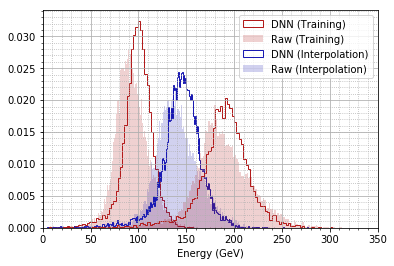

In [344]:
if INTERPOLATION == True:
    
    display = np.array([
        100,
        150,
        200
    ])

    display_inter = np.array([
        150
    ])
    display_train = np.array([
        100,
        200
    ])

    plt.figure()

    for i in display:
        if i in display_inter:
            plt.hist(pred_det_param[i], 
                400,
                histtype = 'step',
                label = 'DNN (Interpolation)',
                density = 'True',
                color = [0.1,0.1,0.7])
            plt.hist(raw_det_fit[i],
                200,
                histtype = 'stepfilled',
                label = 'Raw (Interpolation)',
                alpha = 0.2,
                density = 'True',
                color = [0.1,0.1,0.7])
        if i in display_train:
            plt.hist(pred_det_param[i],
                200,
                histtype = 'step',
                label = 'DNN (Training)',
                     density = 'True',
                color = [0.7,0.1,0.1])
            plt.hist(raw_det_fit[i],
                200,
                histtype = 'stepfilled',
                label = 'Raw (Training)',
                density = 'True',
                alpha = 0.2,
                color = [0.7,0.1,0.1])

    #plt.ylim(0,.1)
    plt.xlabel('Energy (GeV)')
    plt.xlim(0,350)
    
    plt.grid(b = True, which = 'major')
    plt.grid(b = True, which = 'minor', linestyle = ':')
    plt.minorticks_on()

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))

    plt.legend(by_label.values(),
               by_label.keys(),
               loc = 'best')

In [345]:
independent = 1 / np.sqrt( nom_eng_param_list )

slope_pred, intercept_pred, r_pred, p_pred, std_pred = linregress(independent,
                                                                pred_res_param_list)

slope_raw, intercept_raw, r_raw, p_raw, std_raw = linregress(independent,
                                                                raw_res_fit_list)

### Energy Resolution Linearity Plot

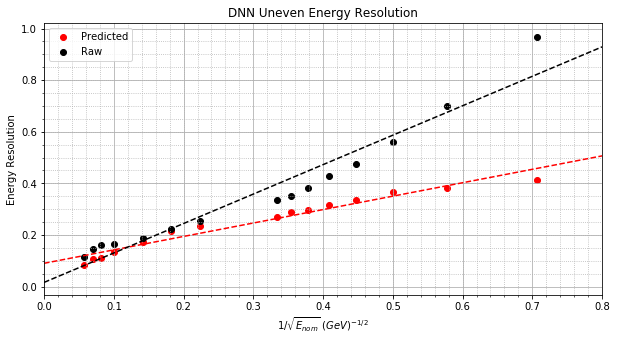

Raw Dataset Linear Regression:(a,b) = (1.14086179658 ± 0.0808302453707, 0.0161287025054)
Trained Dataset Linear Regression:(a,b) = (0.520288632077 ± 0.0316339156834, 0.0901482538486)


In [346]:
def linfit(m,b,x):
    return m*x+b

linfit_range = np.linspace(0,0.8,100)

plt.close()
plt.figure(figsize=(10,5))
plt.scatter(independent, pred_res_param_list,
            marker = 'o', color = 'red',
            label = 'Predicted')
plt.plot(linfit_range, linfit(slope_pred, intercept_pred, linfit_range),
        linestyle = '--', color = 'red')

plt.scatter(independent, raw_res_fit_list,
            marker = 'o', color = 'black',
            label = 'Raw')
plt.plot(linfit_range, linfit(slope_raw, intercept_raw, linfit_range),
        linestyle = '--', color = 'black')

plt.xlabel(r'$1/\sqrt{E_{nom}}\ (GeV)^{-1/2}$')
plt.ylabel('Energy Resolution')
plt.xlim(0,0.8)
plt.title('DNN Uneven Energy Resolution')
plt.grid(b = True, which = 'major')
plt.grid(b = True, which = 'minor', linestyle = ':')
plt.minorticks_on()
plt.legend(loc = 'best')

plt.show()

print('Raw Dataset Linear Regression:' +
    '(a,b) = ({}'.format(slope_raw) + u' \u00B1' + ' {}, {})'.format(std_raw, intercept_raw))
print('Trained Dataset Linear Regression:' + 
    '(a,b) = ({}'.format(slope_pred) + u' \u00B1' + ' {}, {})'.format(std_pred, intercept_pred))

In [347]:
# Wrapper function for np.savetxt

def save_file(filename, x1, y1, x2, y2):
    data_arr = [x1,y1,x2,y2]

    np.save(filename, data_arr)
    
save_file(output_dir + 'DNN Resolution ' + tag + '.npy',
         independent, raw_res_fit_list,
         independent, pred_res_param_list)

### Energy Prediction Accuracy Plot

Split the training and optimization data points for color coding

In [348]:
pred_eng_list_train = []
nom_eng_list_train = []
pred_sigma_list_train = []
pred_eng_list_inter = []
nom_eng_list_inter = []
pred_sigma_list_inter = []

for energy in nom_eng_param_list:
    index = nom_eng_param_list.index(energy)
    if energy in train_list:
        pred_eng_list_train.append(pred_eng_param_list[index])
        nom_eng_list_train.append(energy)
        pred_sigma_list_train.append(pred_sigma_param_list[index])
    else:
        pred_eng_list_inter.append(pred_eng_param_list[index])
        nom_eng_list_inter.append(energy)
        pred_sigma_list_inter.append(pred_sigma_param_list[index])

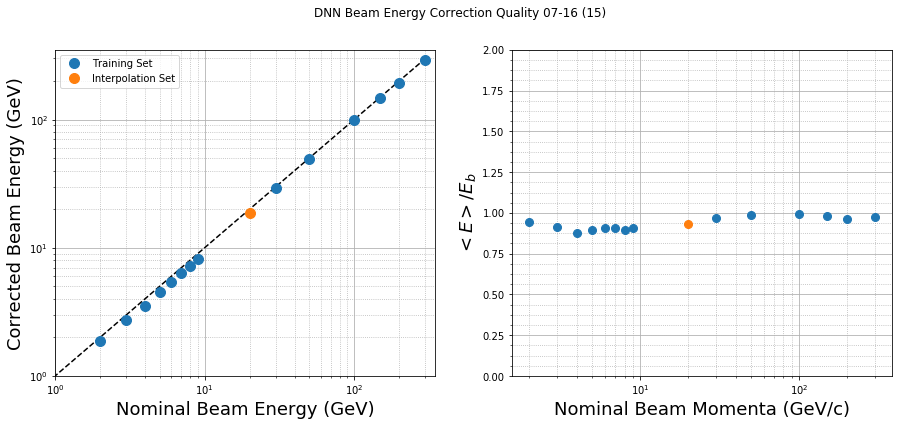

In [349]:
plt.figure(figsize=(15,6))
plt.suptitle('DNN Beam Energy Correction Quality ' + tag)

# left subplot
plt.subplot(121)
plt.plot(np.linspace(-2,300,10),np.linspace(-2,300,10),
         linestyle = '--',
         color = 'k')
plt.plot(nom_eng_list_train, pred_eng_list_train,
        marker = 'o', markersize = 10,
        linestyle = 'none',
        label = 'Training Set')
plt.plot(nom_eng_list_inter, pred_eng_list_inter,
        marker = 'o', markersize = 10,
        linestyle = 'none',
        label = 'Interpolation Set')
plt.ylabel('Corrected Beam Energy (GeV)',
          fontsize = 18)
plt.yscale('log')
plt.xlabel('Nominal Beam Energy (GeV)',
          fontsize = 18)
plt.xscale('log')
plt.grid(b = True, which = 'major')
plt.grid(b = True, which = 'minor', linestyle = ':')
plt.minorticks_on()

if min(pred_eng_list_train) < 1:
    plt.ylim(0.1,60)
    plt.xlim(0.1,60)
else:
    plt.ylim(1,350)
    plt.xlim(1,350)

plt.legend(loc='best')

# compute the percent difference
nom_eng_arr_train = np.asarray( nom_eng_list_train )
pred_eng_arr_train = np.asarray( pred_eng_list_train )
ratio_train = pred_eng_arr_train/ nom_eng_arr_train

nom_eng_arr_inter = np.asarray( nom_eng_list_inter )
pred_eng_arr_inter = np.asarray( pred_eng_list_inter )
ratio_inter = pred_eng_arr_inter / nom_eng_arr_inter

ratio_arr = np.concatenate((ratio_inter,ratio_train))
nom_eng_arr = np.concatenate((nom_eng_arr_inter,nom_eng_arr_train))

ratio_mean = np.around(np.mean(abs(np.concatenate((ratio_inter,ratio_train)))), 4)
ratio_std = np.around(np.std(abs(np.concatenate((ratio_inter,ratio_train)))), 4)

# right subplot
plt.subplot(122)
plt.plot(nom_eng_list_train, ratio_train,
        marker = 'o', markersize = 8,
        linestyle = 'none')
plt.plot(nom_eng_list_inter, ratio_inter,
        marker = 'o', markersize = 8,
        linestyle = 'none')
plt.ylabel(r'$<E>/E_b$',
          fontsize = 18)
plt.ylim(0,2)
plt.xlabel('Nominal Beam Momenta (GeV/c)',
          fontsize = 18)
plt.xscale('log')
plt.grid(b = True, which = 'major')
plt.grid(b = True, which = 'minor', linestyle = ':')
plt.minorticks_on()

#plt.annotate(r'Mean Ratio = {} $\pm$ {}'.format(ratio_mean, ratio_std),
#           xy = (0.03, 0.95), xycoords = 'axes fraction')

plt.savefig(output_dir + 'DNN Correction Quality ' + tag + '.png')

plt.show()

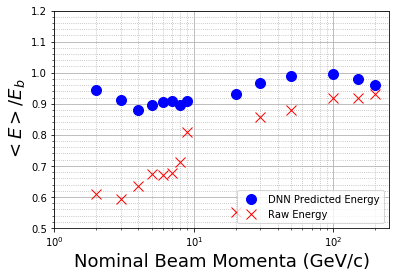

0.9369488791233648
0.037527346512498345


In [350]:
nom_eng_sort = np.asarray(sorted(nom_eng_arr))
ratio_sort = np.asarray([x for _, x in sorted(zip(nom_eng_arr,ratio_arr))])

ratio_raw_arr = np.asarray(raw_eng_fit_list) / np.asarray(nom_eng_param_list)
ratio_raw_sort = np.asarray([x for _, x in sorted(zip(nom_eng_arr,ratio_raw_arr))])

plt.figure()
plt.plot(nom_eng_sort, ratio_sort,
        marker = 'o', markersize = 10,
        linestyle = 'none',
        label = 'DNN Predicted Energy',
        color = 'b')
plt.plot(nom_eng_sort, ratio_raw_sort,
        marker = 'x', markersize = 10,
        linestyle = 'none',
        label = 'Raw Energy',
        color = 'r'
        )
plt.ylabel(r'$<E>/E_b$',
          fontsize = 18)
plt.xlim(1,250)
plt.ylim(0.5,1.2)
plt.xlabel('Nominal Beam Momenta (GeV/c)',
          fontsize = 18)
plt.xscale('log')
plt.grid(b = True, which = 'major')
plt.grid(b = True, which = 'minor', linestyle = ':')
plt.minorticks_on()

plt.legend(loc = 4)
plt.show()

print(np.mean(ratio_sort))
print(np.std(ratio_sort))

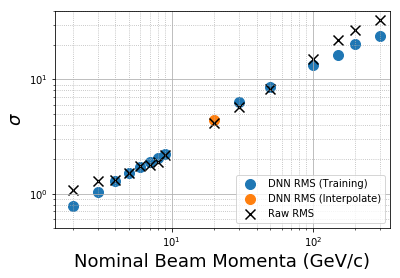

In [351]:
plt.figure()
plt.scatter(nom_eng_list_train, pred_sigma_list_train,
           s = 100,
           label = 'DNN RMS (Training)')
plt.scatter(nom_eng_list_inter, pred_sigma_list_inter,
           s = 100,
           label = 'DNN RMS (Interpolate)')
plt.scatter(nom_eng_param_list, raw_sigma_fit_list,
           marker = 'x', s = 100,
           label = 'Raw RMS',
           color = 'k')

plt.xlabel('Nominal Beam Momenta (GeV/c)',
          fontsize = 18)
plt.xscale('log')
plt.xlim(1.5,350)
plt.ylim(0.5,40)
plt.ylabel(r'$\sigma$',
          fontsize = 18)
plt.yscale('log')

plt.grid(b = True, which = 'major')
plt.grid(b = True, which = 'minor', linestyle = ':')
plt.minorticks_on()

plt.legend(loc = 4)
plt.show()

In [352]:
def save_ratio(filename, x1, y1):
    data_arr = [x1,y1]

    np.save(filename, data_arr)
if INTERPOLATION == False:
    save_ratio(output_dir + "DNN Ratio " + tag + ".npy",
          nom_eng_sort, ratio_sort)

    save_ratio("./Analysis Results/raw_mean_ratios.npy",
        nom_eng_sort, ratio_raw_sort)